# Credit Default Risk Modeling – Production Triage Pipeline

This notebook implements an **industry-grade credit risk decision system** using:
- LightGBM
- Advanced feature engineering
- Class imbalance handling
- **Dual-threshold triage (Approve / Reject / Review)**

Goal: **Near-zero FP in approvals and near-zero FN in rejections**.

In [15]:
import os
import joblib
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.metrics import (
    roc_auc_score,
    classification_report,
    confusion_matrix,
    roc_curve
)

from lightgbm import LGBMClassifier


In [16]:
# ---------------- CONFIG ----------------
DATA_PATH = "../data/credit_data.csv"
MODEL_DIR = "../model"
MODEL_PATH = "../model/triage_model.pkl"
RANDOM_STATE = 42
TARGET = "SeriousDlqin2yrs"

LOW_RISK_THRESHOLD = 0.25
HIGH_RISK_THRESHOLD = 0.75

os.makedirs(MODEL_DIR, exist_ok=True)

In [17]:
# ---------------- LOAD DATA ----------------
df = pd.read_csv(DATA_PATH)
df = df.dropna(subset=[TARGET])
print("Dataset shape:", df.shape)

Dataset shape: (150000, 12)


In [18]:
# ---------------- FEATURE ENGINEERING ----------------
df = df.copy()

df["RevolvingUtilizationOfUnsecuredLines"] = df["RevolvingUtilizationOfUnsecuredLines"].clip(upper=10)

df["MonthlyIncome_clipped"] = df["MonthlyIncome"].clip(lower=0)
df["MonthlyIncome_log"] = np.log1p(df["MonthlyIncome_clipped"])
df["MonthlyIncome_missing"] = df["MonthlyIncome"].isna().astype(int)

df["NumberOfDependents_missing"] = df["NumberOfDependents"].isna().astype(int)

df["num_delinquencies"] = (
    df["NumberOfTime30-59DaysPastDueNotWorse"].fillna(0)
    + df["NumberOfTime60-89DaysPastDueNotWorse"].fillna(0)
    + df["NumberOfTimes90DaysLate"].fillna(0)
)

df["severe_delinquency"] = (df["NumberOfTimes90DaysLate"] > 0).astype(int)
df["high_debt_ratio"] = (df["DebtRatio"] > 1).astype(int)

df["util_x_open_accounts"] = df["RevolvingUtilizationOfUnsecuredLines"] * df["NumberOfOpenCreditLinesAndLoans"].fillna(0)

df["delinq_per_account"] = df["num_delinquencies"] / (
    df["NumberOfOpenCreditLinesAndLoans"].replace(0, np.nan).fillna(1)
)

df["debt_to_income"] = df["DebtRatio"] / (df["MonthlyIncome_clipped"] + 1)
df["credit_per_account"] = df["MonthlyIncome_clipped"] / (df["NumberOfOpenCreditLinesAndLoans"] + 1)

df["age_risk"] = pd.cut(df["age"], bins=[0,25,35,50,65,100], labels=False)

In [19]:
# ---------------- FEATURE SET ----------------
feature_cols = [
    "RevolvingUtilizationOfUnsecuredLines","age",
    "NumberOfTime30-59DaysPastDueNotWorse",
    "NumberOfTime60-89DaysPastDueNotWorse",
    "NumberOfTimes90DaysLate","DebtRatio",
    "MonthlyIncome_log","MonthlyIncome_missing",
    "NumberOfOpenCreditLinesAndLoans",
    "NumberRealEstateLoansOrLines",
    "NumberOfDependents","NumberOfDependents_missing",
    "num_delinquencies","severe_delinquency",
    "high_debt_ratio","util_x_open_accounts",
    "delinq_per_account","debt_to_income",
    "credit_per_account","age_risk"
]

X = df[feature_cols]
y = df[TARGET].astype(int)

In [20]:
# ---------------- TRAIN TEST SPLIT ----------------
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=RANDOM_STATE
)

In [21]:
# ---------------- PIPELINE ----------------
preprocessor = ColumnTransformer([
    ("num", SimpleImputer(strategy="median"), feature_cols)
])

scale_pos_weight = (len(y_train) - y_train.sum()) / y_train.sum()

model = LGBMClassifier(
    n_estimators=1800,
    learning_rate=0.02,
    num_leaves=128,
    min_child_samples=25,
    subsample=0.75,
    colsample_bytree=0.75,
    scale_pos_weight=2.0 * scale_pos_weight,
    reg_alpha=0.05,
    reg_lambda=0.2,
    random_state=RANDOM_STATE,
    n_jobs=-1
)

pipeline = Pipeline([
    ("preprocessor", preprocessor),
    ("model", model)
])

In [22]:
# ---------------- TRAIN ----------------
pipeline.fit(X_train, y_train)

[LightGBM] [Info] Number of positive: 8021, number of negative: 111979
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.011482 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1939
[LightGBM] [Info] Number of data points in the train set: 120000, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.066842 -> initscore=-2.636248
[LightGBM] [Info] Start training from score -2.636248


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  SimpleImputer(strategy='median'),
                                                  ['RevolvingUtilizationOfUnsecuredLines',
                                                   'age',
                                                   'NumberOfTime30-59DaysPastDueNotWorse',
                                                   'NumberOfTime60-89DaysPastDueNotWorse',
                                                   'NumberOfTimes90DaysLate',
                                                   'DebtRatio',
                                                   'MonthlyIncome_log',
                                                   'MonthlyIncome_missing',
                                                   'NumberOfOpenCreditLinesAndLoans',
                                                   'Numbe...
                                                   'high_debt_ratio',
                                                   'util_x_open_accounts',
                                                   'delinq_per_account',
                                                   'debt_to_income',
                                                   'credit_per_account',
                                                   'age_risk'])])),
                ('model',
                 LGBMClassifier(colsample_bytree=0.75, learning_rate=0.02,
                                min_child_samples=25, n_estimators=1800,
                                n_jobs=-1, num_leaves=128, random_state=42,
                                reg_alpha=0.05, reg_lambda=0.2,
                                scale_pos_weight=np.float64(27.921456177533972),
                                subsample=0.75))])

In [23]:
# ---------------- TRIAGE DECISION ----------------
proba = pipeline.predict_proba(X_test)[:, 1]

def triage(p):
    if p <= LOW_RISK_THRESHOLD:
        return 0
    elif p >= HIGH_RISK_THRESHOLD:
        return 1
    else:
        return -1

decisions = np.array([triage(p) for p in proba])

C:\Users\Dev\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


In [24]:
# ---------------- AUTO-DECISION EVALUATION ----------------
mask = decisions != -1

y_auto = y_test[mask]
preds_auto = decisions[mask]

coverage = mask.mean()

print(f"Auto-decision coverage: {coverage:.2%}")
print(classification_report(y_auto, preds_auto, digits=4))

Auto-decision coverage: 77.59%
              precision    recall  f1-score   support

           0     0.9790    0.9403    0.9593     21993
           1     0.3904    0.6550    0.4892      1284

    accuracy                         0.9246     23277
   macro avg     0.6847    0.7976    0.7243     23277
weighted avg     0.9466    0.9246    0.9333     23277



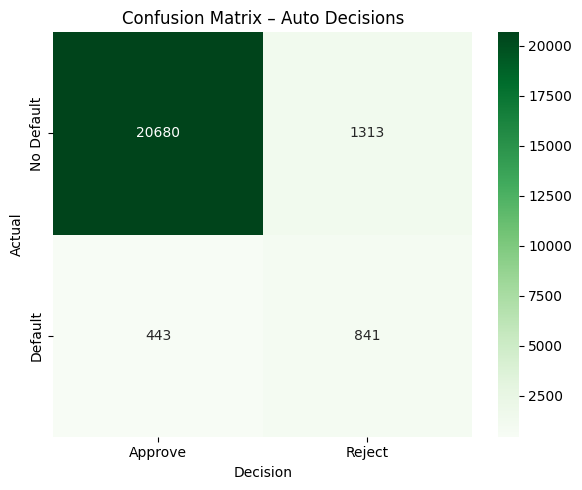

In [25]:
# ---------------- CONFUSION MATRIX ----------------
cm = confusion_matrix(y_auto, preds_auto)

plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Greens",
            xticklabels=["Approve", "Reject"],
            yticklabels=["No Default", "Default"])

plt.title("Confusion Matrix – Auto Decisions")
plt.xlabel("Decision")
plt.ylabel("Actual")
plt.tight_layout()
plt.show()

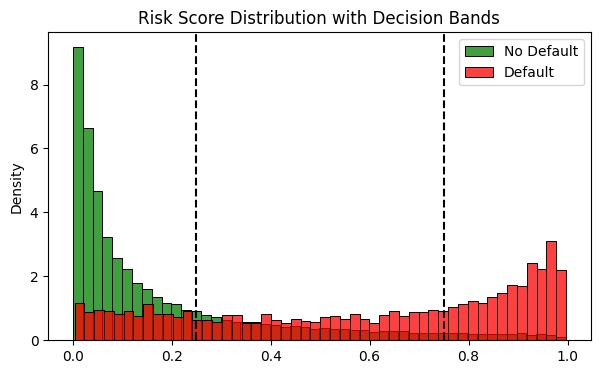

In [26]:
# ---------------- RISK DISTRIBUTION ----------------
plt.figure(figsize=(7,4))
sns.histplot(proba[y_test==0], bins=50, color="green", stat="density", label="No Default")
sns.histplot(proba[y_test==1], bins=50, color="red", stat="density", label="Default")

plt.axvline(LOW_RISK_THRESHOLD, linestyle="--", color="black")
plt.axvline(HIGH_RISK_THRESHOLD, linestyle="--", color="black")

plt.legend()
plt.title("Risk Score Distribution with Decision Bands")
plt.show()

In [27]:
# ---------------- SAVE ARTIFACT ----------------
artifact = {
    "pipeline": pipeline,
    "features": feature_cols,
    "target": TARGET,
    "low_risk_threshold": LOW_RISK_THRESHOLD,
    "high_risk_threshold": HIGH_RISK_THRESHOLD,
    "auto_coverage": coverage,
    "confusion_matrix_auto": cm.tolist()
}

joblib.dump(artifact, MODEL_PATH)
print("Triage model artifact saved")

Triage model artifact saved
